# Intermittent Math Modelling

This notebook focuses on mathematical modeling of intermittent treatment data for cancer cell growth dynamics.
Data is extracted from the organized processed datasets with exact seeding densities (20k and 30k).

In [1]:
# Essential packages for intermittent treatment modeling should only run once per project
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("Optimization")
Pkg.add("OptimizationOptimJL")
Pkg.add("OptimizationBBO")
Pkg.add("DiffEqParamEstim")
Pkg.add("StatsBase")
Pkg.add("SciMLSensitivity")
Pkg.add("BlackBoxOptim")
Pkg.add("StatsPlots")
Pkg.add("DataFramesMeta")
Pkg.add("Interact")
Pkg.add("Random")
Pkg.add("Distributions")

    Updating registry at `C:\Users\MainFrameTower\.julia\registries\General.toml`
   Resolving package versions...
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed DataAPI ───────────────────── v1.16.0
   Installed SentinelArrays ────────────── v1.4.8
   Installed PooledArrays ──────────────── v1.4.3
   Installed InlineStrings ─────────────── v1.4.5
   Installed TableTraits ───────────────── v1.0.1
   Installed Tables ────────────────────── v1.12.1
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed DataAPI ───────────────────── v1.16.0
   Installed SentinelArrays ────────────── v1.4.8
   Installed PooledArrays ──────────────── v1.4.3
   Installed InlineStrings ─────────────── v1.4.5
   Installed TableTraits ───────────────── v1.0.1
   Installed Tables ────────────────────── v1.12.1
   Installed DataValueInterfaces ───────── v1.0.0
   Installed DataValueInterfaces ───────── v1.0.0
   Installed Compat ────────────────────── v4.18.0
   Installed Compat ──────────

In [2]:
using CSV
using DataFrames
using Plots
using DifferentialEquations
using Optimization, OptimizationOptimJL, OptimizationBBO
using BlackBoxOptim
using StatsBase
using Random
using Distributions
using Printf
using Statistics

In [3]:
# Core modeling functions
function setUpProblem(modelTypeSet, xdataSet, ydataSet, solverSet, u0Set, pSet, tspanSet, boundsSet)
    best_params, best_sol, best_prob, best_loss = nothing, nothing, nothing, Inf

    for _ in 1:5
        p_init = [lo[1] == lo[2] ? lo[1] : rand(Uniform(lo[1], lo[2])) for lo in boundsSet]

        try
            prob = ODEProblem(modelTypeSet, u0Set, tspanSet, p_init)
            loss_func = build_loss_objective(prob, solverSet, L2Loss(xdataSet, ydataSet), Optimization.AutoForwardDiff())
            result = bboptimize(loss_func; SearchRange=boundsSet, MaxTime=30.0, TraceMode=:silent)
            p_opt = best_candidate(result)
            sol = solve(remake(prob, p=p_opt), solverSet, saveat=xdataSet)
            loss = sum(abs2.(ydataSet .- [u[1] for u in sol.u]))

            if loss < best_loss
                best_params, best_sol, best_prob, best_loss = p_opt, sol, prob, loss
            end
        catch; end
    end

    return best_params, best_sol, best_prob
end

function calculate_bic(probbic, xdatabic, ydatabic, solverbic, optparbic)
    solbic = solve(probbic, solverbic, reltol=1e-15, abstol=1e-15, saveat=xdatabic)
    residualsbic = [ydatabic[i] - solbic(xdatabic[i])[1] for i in 1:length(xdatabic)]
    ssrbic = sum(residualsbic .^ 2)
    kbic = length(optparbic)
    nbic = length(xdatabic)
    bic = nbic * log(ssrbic / nbic) + kbic * log(nbic)
    return bic, ssrbic
end

function plot_model_fit(x, y, optimized_params, optimized_sol, bic, ssr, title_str)
    println("\nOptimized Parameters: ", round.(optimized_params, digits=4))
    println("Sum of Squared Residuals (SSR): ", round(ssr, digits=6))
    println("Bayesian Information Criterion (BIC): ", round(bic, digits=2))
    
    p = plot(x, y, label="Data", legend=:bottomright, title=title_str, xlabel="Day", ylabel="Cell Count", 
             lw=2, marker=:circle, markersize=4)
    plot!(optimized_sol.t, [u[1] for u in optimized_sol.u], label="Model", lw=3, linestyle=:dash)
    
    display(p)
    return p
end

plot_model_fit (generic function with 1 method)

In [17]:
# Load intermittent data from processed datasets
function load_intermittent_data(seeding_density::String)
    base_path = "Processed_Datasets/Intermittent Data/$(seeding_density)_seeding_density/Averages/"
    
    # Define file mappings
    files = [
        "A2780T_dayaverages.csv",     # Naive treated
        "A2780UT_dayaverages.csv",    # Naive untreated  
        "A2780cisT_dayaverages.csv",  # Resistant treated
        "A2780cisUT_dayaverages.csv"  # Resistant untreated
    ]
    
    datasets = Dict{String, DataFrame}()
    
    for file in files
        try
            df = CSV.read(base_path * file, DataFrame)
            datasets[file] = df
            println("✅ Loaded: ", file, " ($(nrow(df)) rows)")
        catch e
            println("❌ Failed to load: $file")
            println("   ↳ Error: ", e)
        end
    end
    
    return datasets
end

# Extract x,y data from day averages CSV (data is already preprocessed)
function extract_xy_from_dayaverages(df::DataFrame)
    # Extract day and cell count data from preprocessed CSV
    x = Float64.(df[:, 1])  # First column (days)
    y = Float64.(df[:, 2])  # Second column (cell counts) - already processed
    
    println("   → Data range: Day $(x[1])-$(x[end]), Cell count $(minimum(y))-$(maximum(y))")
    return x, y
end

extract_xy_from_dayaverages (generic function with 1 method)

In [18]:
# Mathematical models for intermittent treatment

# 1. Standard logistic growth (for comparison)
function logistic_growth!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1] / K)
end

# 2. Early treatment with lingering decay (T files: treated 0-7, untreated 7-14)
function early_treatment_decay!(du, u, p, t)
    r, K, drug_effect, decay_rate = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment (days 0-7): full drug effect
        current_drug_effect = drug_effect
    else
        # Post-treatment (days 7-14): exponential decay of lingering effect
        time_since_treatment = t - treatment_end
        current_drug_effect = drug_effect * exp(-time_since_treatment / decay_rate)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 3. Late treatment (UT files: untreated 0-7, treated 7-14)
function late_treatment!(du, u, p, t)
    r, K, drug_effect = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment (days 0-7): no drug effect
        current_drug_effect = 0.0
    else
        # During treatment (days 7-14): full drug effect
        current_drug_effect = drug_effect
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 4. Early treatment with biphasic decay (fast + slow clearance)
function early_treatment_biphasic!(du, u, p, t)
    r, K, drug_effect, fast_decay, slow_decay, fast_fraction = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: biphasic decay
        time_since_end = t - treatment_end
        fast_component = fast_fraction * exp(-time_since_end / fast_decay)
        slow_component = (1 - fast_fraction) * exp(-time_since_end / slow_decay)
        current_drug_effect = drug_effect * (fast_component + slow_component)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 5. Early treatment with power law decay (very persistent effects)
function early_treatment_powerlaw!(du, u, p, t)
    r, K, drug_effect, decay_exponent, time_scale = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: power law decay
        time_since_end = t - treatment_end
        current_drug_effect = drug_effect / (1 + (time_since_end / time_scale)^decay_exponent)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 6. Late treatment with immediate effect buildup
function late_treatment_buildup!(du, u, p, t)
    r, K, drug_effect, buildup_rate = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no effect
        current_drug_effect = 0.0
    else
        # During treatment: gradual buildup to full effect
        time_in_treatment = t - treatment_start
        current_drug_effect = drug_effect * (1 - exp(-time_in_treatment / buildup_rate))
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 7. Early treatment with Hill effect (T files: treated 0-7, untreated 7-14)
function early_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: Hill function increases effect over time
        current_drug_effect = max_drug_effect * (t^hill_coeff) / (t^hill_coeff + half_effect_time^hill_coeff)
    else
        # Post-treatment: no drug effect (immediate clearance)
        current_drug_effect = 0.0
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 8. Late treatment with Hill effect (UT files: untreated 0-7, treated 7-14)
function late_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no drug effect
        current_drug_effect = 0.0
    else
        # During treatment: Hill function increases effect over time in treatment
        time_in_treatment = t - treatment_start
        current_drug_effect = max_drug_effect * (time_in_treatment^hill_coeff) / (time_in_treatment^hill_coeff + half_effect_time^hill_coeff)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

late_treatment_hill! (generic function with 1 method)

Loading 20k seeding density data...
✅ Loaded: A2780T_dayaverages.csv (14 rows)
✅ Loaded: A2780UT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisUT_dayaverages.csv (14 rows)

📊 Processing: A2780cisT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 84.95524691358025-4098.231018518519
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)

   → Data range: Day 1.0-14.0, Cell count 84.95524691358025-4098.231018518519
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


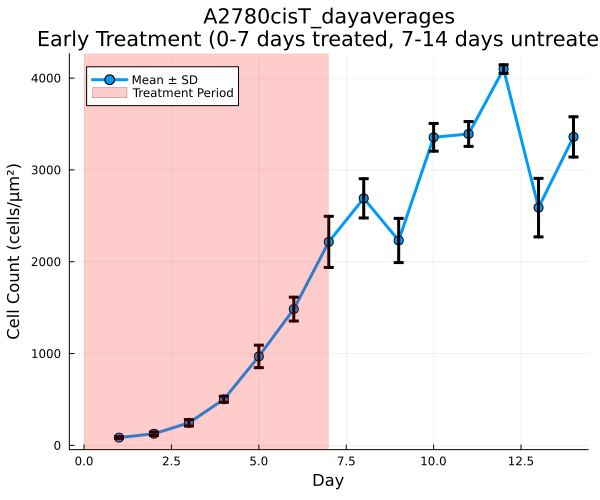


📊 Processing: A2780T_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 164.70011574074073-2859.6863425925926
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


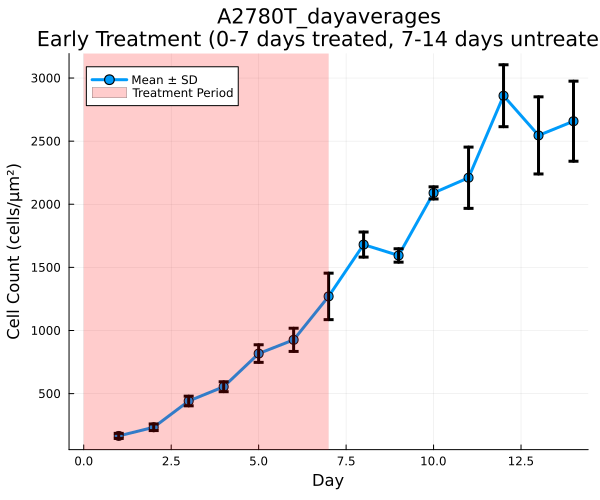


📊 Processing: A2780cisUT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 43.80231481481482-3813.640779320988
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


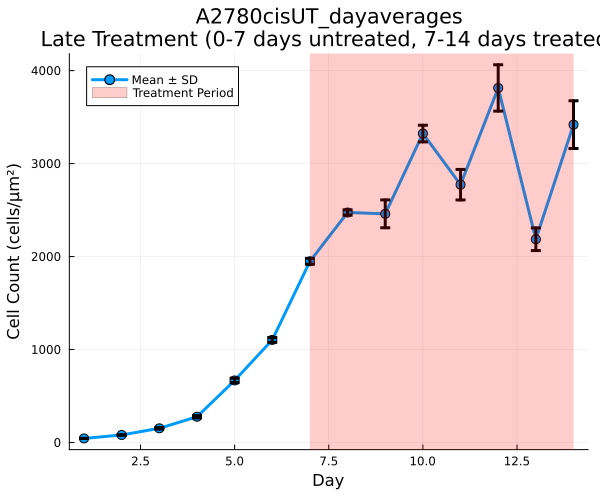


📊 Processing: A2780UT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 70.98599537037036-3088.9737268518525
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


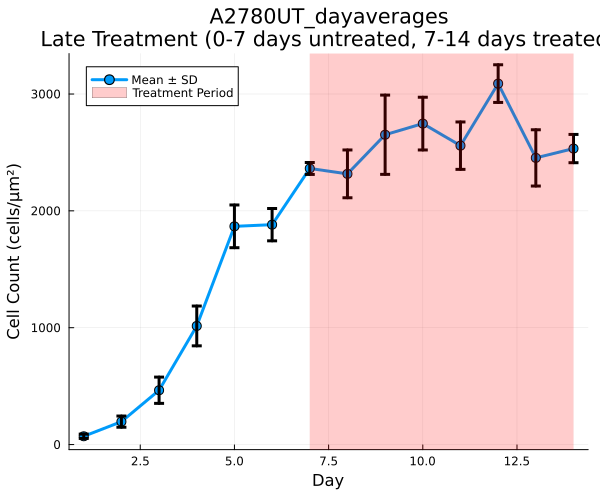


📈 Displaying combined overview for 20k seeding density...


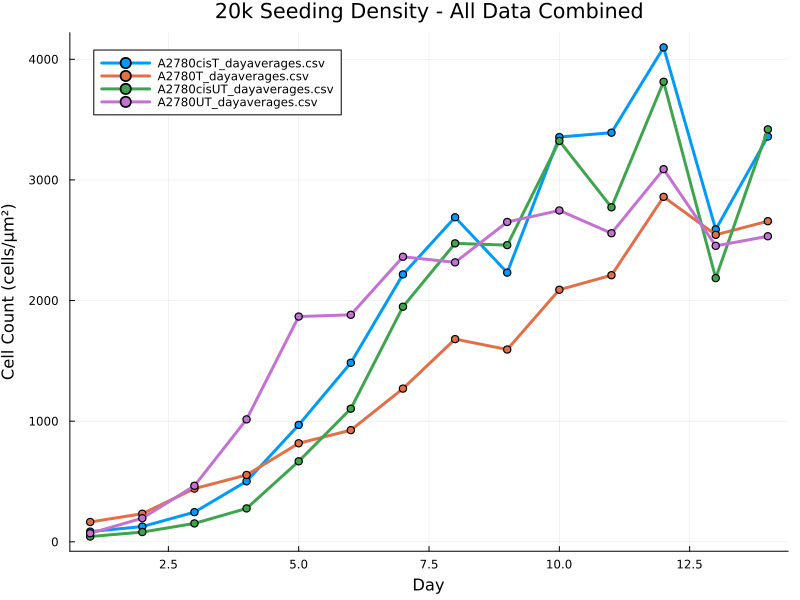


📊 Displaying treatment-specific combined plots...


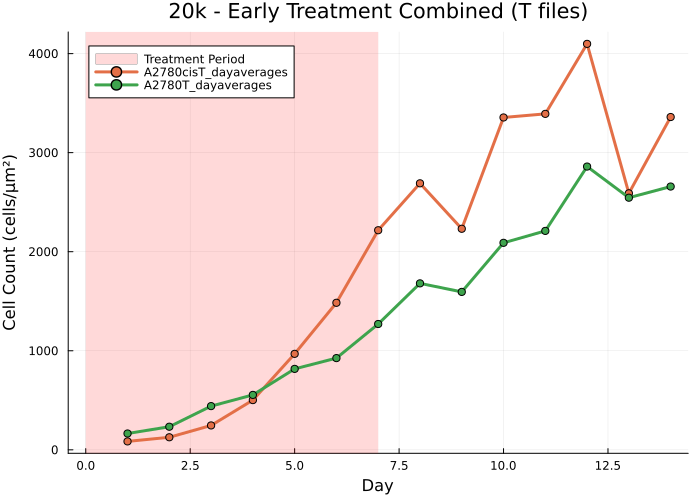

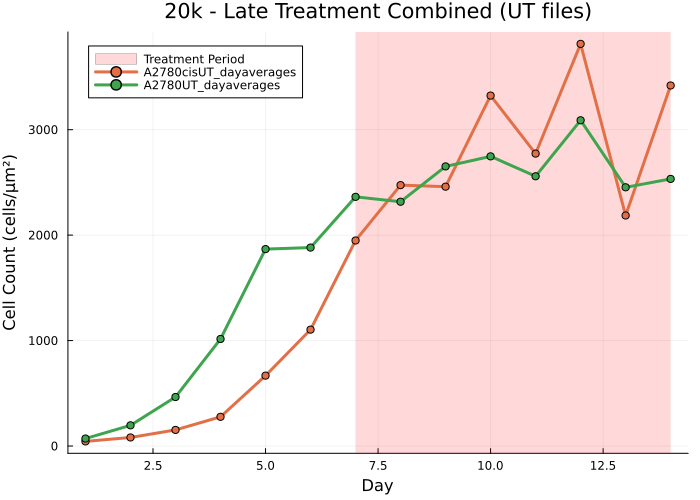

In [20]:
# Load and analyze 20k seeding density data
println("Loading 20k seeding density data...")
datasets_20k = load_intermittent_data("20k")

# Initialize storage for results
results_20k = Dict{String, Any}()
xy_data_20k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create combined overview plot
plot_all_combined = plot(title="20k Seeding Density - All Data Combined", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(800, 600))

# Process each dataset and create individual plots with error bars
for (filename, df) in datasets_20k
    println("\n📊 Processing: $filename")
    
    # Extract data including error information
    days = Float64.(df[:, 1])  # Day column
    mean_counts = Float64.(df[:, 2])  # Mean_Cells_um2 column
    std_devs = Float64.(df[:, 3])  # Std_Dev_um2 column
    
    # Store x,y data for later use
    xy_data_20k[filename] = (days, mean_counts)
    
    # Add to combined plot
    plot!(plot_all_combined, days, mean_counts, label=filename, lw=3, marker=:circle, markersize=4)
    
    # Create individual plot with error bars
    cell_type = replace(filename, ".csv" => "")
    treatment_info = if occursin("T_", filename) && !occursin("UT_", filename)
        "Early Treatment (0-7 days treated, 7-14 days untreated)"
    elseif occursin("UT_", filename)
        "Late Treatment (0-7 days untreated, 7-14 days treated)"
    else
        "Unknown treatment pattern"
    end
    
    individual_plot = plot(
        title="$cell_type\n$treatment_info",
        xlabel="Day", 
        ylabel="Cell Count (cells/μm²)",
        legend=:topleft,
        size=(600, 500)
    )
    
    # Plot with error bars (using standard deviation)
    plot!(individual_plot, days, mean_counts, 
          yerror=std_devs,
          label="Mean ± SD", 
          lw=3, 
          marker=:circle, 
          markersize=5,
          capsize=3)
    
    # Add treatment period indicators
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment: shade 0-7 days
        vspan!(individual_plot, [0, 7], alpha=0.2, color=:red, label="Treatment Period")
    elseif occursin("UT_", filename)
        # Late treatment: shade 7-14 days
        vspan!(individual_plot, [7, 14], alpha=0.2, color=:red, label="Treatment Period")
    end
    
    println("   → Data range: Day $(days[1])-$(days[end]), Cell count $(minimum(mean_counts))-$(maximum(mean_counts))")
    println("   → Treatment type: $treatment_info")
    
    # Display individual plot
    display(individual_plot)
    
    # Store empty results since we're not doing model fitting
    results_20k[filename] = []
end

# Display combined overview plot
println("\n📈 Displaying combined overview for 20k seeding density...")
display(plot_all_combined)

# Create treatment-specific combined plots
plot_early_combined = plot(title="20k - Early Treatment Combined (T files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))
plot_late_combined = plot(title="20k - Late Treatment Combined (UT files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))

# Add treatment period shading
vspan!(plot_early_combined, [0, 7], alpha=0.15, color=:red, label="Treatment Period")
vspan!(plot_late_combined, [7, 14], alpha=0.15, color=:red, label="Treatment Period")

for (filename, df) in datasets_20k
    days = Float64.(df[:, 1])
    mean_counts = Float64.(df[:, 2])
    
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment files
        plot!(plot_early_combined, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    elseif occursin("UT_", filename)
        # Late treatment files  
        plot!(plot_late_combined, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    end
end

println("\n📊 Displaying treatment-specific combined plots...")
display(plot_early_combined)
display(plot_late_combined)


Loading 30k seeding density data...
✅ Loaded: A2780T_dayaverages.csv (14 rows)
✅ Loaded: A2780UT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisUT_dayaverages.csv (14 rows)

📊 Processing: A2780cisT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 107.89394290123457-4007.9396604938265
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


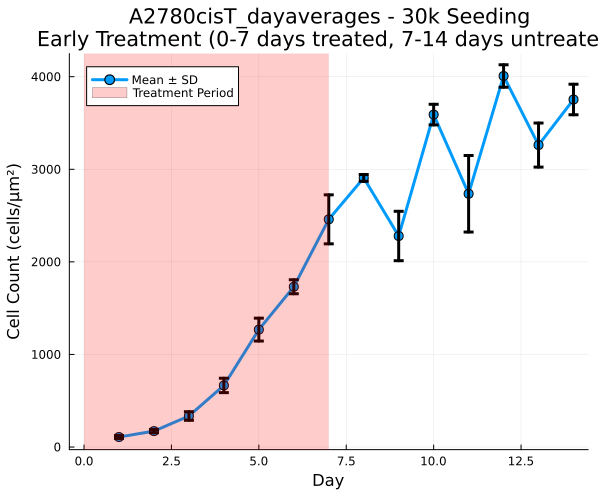


📊 Processing: A2780T_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 288.98688271604937-2716.687654320988
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


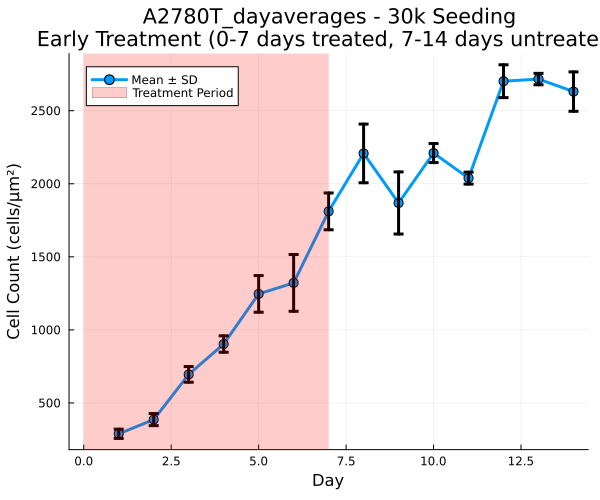


📊 Processing: A2780cisUT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 68.5091049382716-3735.9834104938273
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


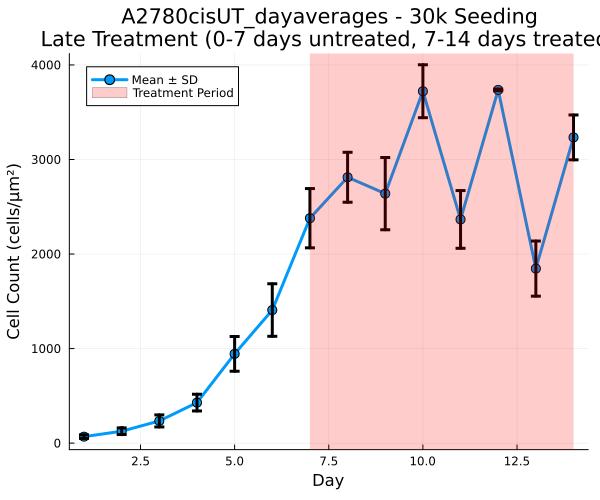


📊 Processing: A2780UT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 89.00717592592594-3023.571913580247
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


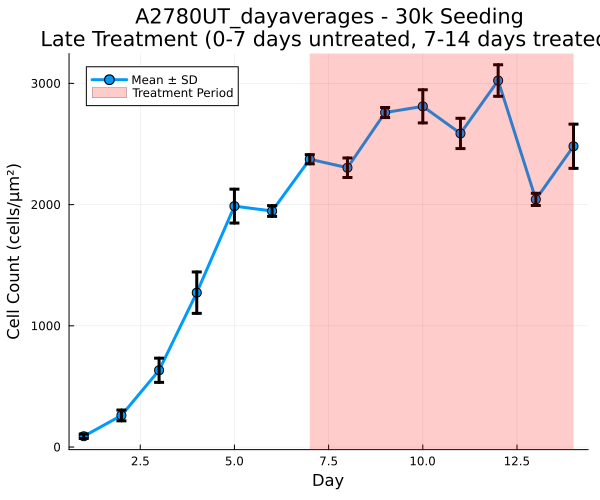


📈 Displaying combined overview for 30k seeding density...


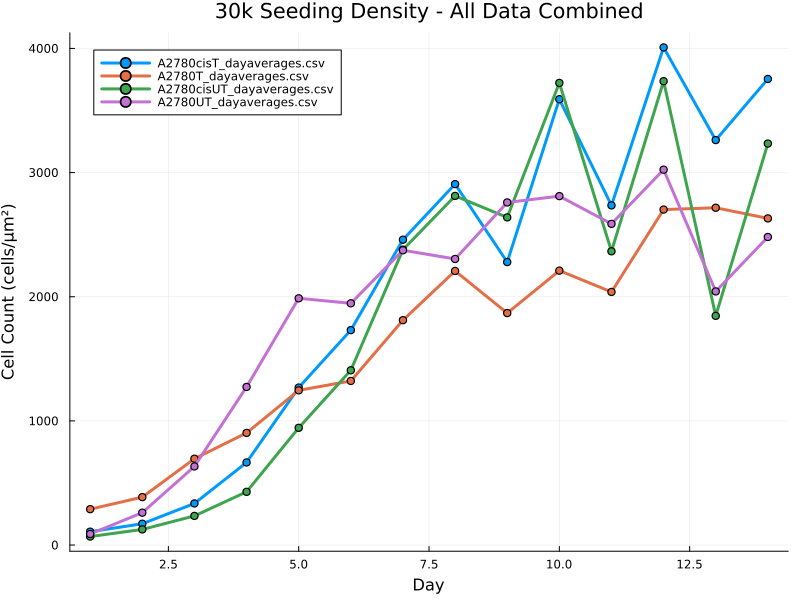


📊 Displaying treatment-specific combined plots...


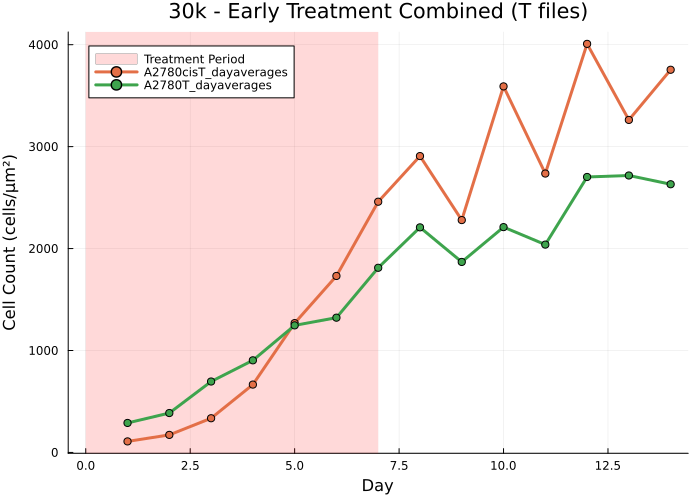

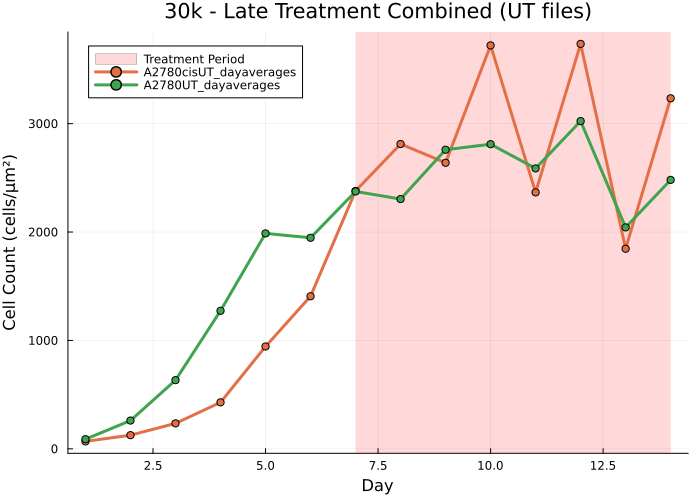

In [21]:
# Load and analyze 30k seeding density data
println("\nLoading 30k seeding density data...")
datasets_30k = load_intermittent_data("30k")

# Initialize storage for results
results_30k = Dict{String, Any}()
xy_data_30k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create combined overview plot
plot_all_combined_30k = plot(title="30k Seeding Density - All Data Combined", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(800, 600))

# Process each dataset and create individual plots with error bars
for (filename, df) in datasets_30k
    println("\n📊 Processing: $filename")
    
    # Extract data including error information
    days = Float64.(df[:, 1])  # Day column
    mean_counts = Float64.(df[:, 2])  # Mean_Cells_um2 column
    std_devs = Float64.(df[:, 3])  # Std_Dev_um2 column
    
    # Store x,y data for later use
    xy_data_30k[filename] = (days, mean_counts)
    
    # Add to combined plot
    plot!(plot_all_combined_30k, days, mean_counts, label=filename, lw=3, marker=:circle, markersize=4)
    
    # Create individual plot with error bars
    cell_type = replace(filename, ".csv" => "")
    treatment_info = if occursin("T_", filename) && !occursin("UT_", filename)
        "Early Treatment (0-7 days treated, 7-14 days untreated)"
    elseif occursin("UT_", filename)
        "Late Treatment (0-7 days untreated, 7-14 days treated)"
    else
        "Unknown treatment pattern"
    end
    
    individual_plot = plot(
        title="$cell_type - 30k Seeding\n$treatment_info",
        xlabel="Day", 
        ylabel="Cell Count (cells/μm²)",
        legend=:topleft,
        size=(600, 500)
    )
    
    # Plot with error bars (using standard deviation)
    plot!(individual_plot, days, mean_counts, 
          yerror=std_devs,
          label="Mean ± SD", 
          lw=3, 
          marker=:circle, 
          markersize=5,
          capsize=3)
    
    # Add treatment period indicators
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment: shade 0-7 days
        vspan!(individual_plot, [0, 7], alpha=0.2, color=:red, label="Treatment Period")
    elseif occursin("UT_", filename)
        # Late treatment: shade 7-14 days
        vspan!(individual_plot, [7, 14], alpha=0.2, color=:red, label="Treatment Period")
    end
    
    println("   → Data range: Day $(days[1])-$(days[end]), Cell count $(minimum(mean_counts))-$(maximum(mean_counts))")
    println("   → Treatment type: $treatment_info")
    
    # Display individual plot
    display(individual_plot)
    
    # Store empty results since we're not doing model fitting
    results_30k[filename] = []
end

# Display combined overview plot
println("\n📈 Displaying combined overview for 30k seeding density...")
display(plot_all_combined_30k)

# Create treatment-specific combined plots
plot_early_combined_30k = plot(title="30k - Early Treatment Combined (T files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))
plot_late_combined_30k = plot(title="30k - Late Treatment Combined (UT files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))

# Add treatment period shading
vspan!(plot_early_combined_30k, [0, 7], alpha=0.15, color=:red, label="Treatment Period")
vspan!(plot_late_combined_30k, [7, 14], alpha=0.15, color=:red, label="Treatment Period")

for (filename, df) in datasets_30k
    days = Float64.(df[:, 1])
    mean_counts = Float64.(df[:, 2])
    
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment files
        plot!(plot_early_combined_30k, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    elseif occursin("UT_", filename)
        # Late treatment files  
        plot!(plot_late_combined_30k, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    end
end

println("\n📊 Displaying treatment-specific combined plots...")
display(plot_early_combined_30k)
display(plot_late_combined_30k)

In [15]:
# Summary and comparison of results
function summarize_results(results_dict, seeding_density)
    println("\n" * "="^60)
    println("SUMMARY: $seeding_density Seeding Density Results")
    println("="^60)
    
    summary_data = []
    
    for (filename, file_results) in results_dict
        println("\n📁 $filename:")
        
        if !isempty(file_results)
            # Sort by BIC (lower is better)
            sorted_results = sort(file_results, by = x -> x[5])
            
            for (i, (model_name, params, sol, prob, bic, ssr)) in enumerate(sorted_results)
                rank_symbol = i == 1 ? "🥇" : i == 2 ? "🥈" : i == 3 ? "🥉" : "  "
                println("  $rank_symbol $model_name: BIC = $(round(bic, digits=2)), SSR = $(round(ssr, digits=6))")
                println("     Parameters: $(round.(params, digits=4))")
                
                push!(summary_data, (
                    SeeddingDensity = seeding_density,
                    File = filename,
                    Model = model_name,
                    BIC = bic,
                    SSR = ssr,
                    Parameters = join(round.(params, digits=4), ", "),
                    Rank = i
                ))
            end
        else
            println("  ❌ No successful fits")
        end
    end
    
    return summary_data
end

# Generate summaries
summary_20k = summarize_results(results_20k, "20k")
summary_30k = summarize_results(results_30k, "30k")

# Combine and save results
all_summaries = vcat(summary_20k, summary_30k)
summary_df = DataFrame(all_summaries)

# Save to CSV
CSV.write("intermittent_modeling_results.csv", summary_df)
println("\n💾 Results saved to: intermittent_modeling_results.csv")


SUMMARY: 20k Seeding Density Results

📁 A2780cisT_dayaverages.csv:
  ❌ No successful fits

📁 A2780T_dayaverages.csv:
  ❌ No successful fits

SUMMARY: 30k Seeding Density Results

📁 A2780cisT_dayaverages.csv:
  ❌ No successful fits

📁 A2780T_dayaverages.csv:
  ❌ No successful fits

📁 A2780cisUT_dayaverages.csv:
  ❌ No successful fits

📁 A2780UT_dayaverages.csv:
  ❌ No successful fits

💾 Results saved to: intermittent_modeling_results.csv


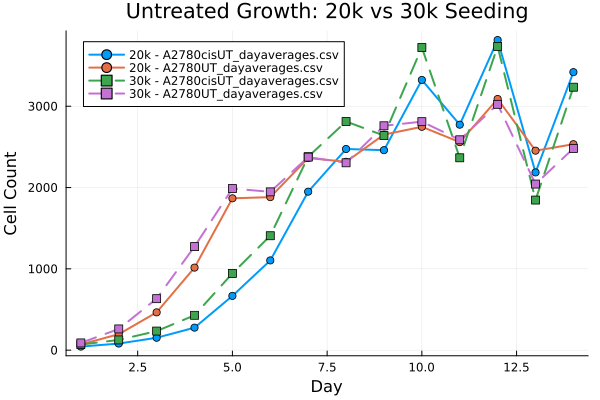

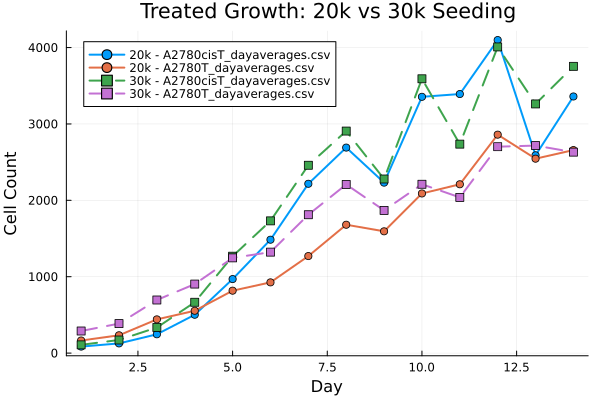

In [16]:
# Comparative plots: 20k vs 30k seeding densities
function create_comparative_plots()
    # Compare untreated growth between seeding densities
    plt_untreated = plot(title="Untreated Growth: 20k vs 30k Seeding", xlabel="Day", ylabel="Cell Count")
    
    # Plot 20k untreated data
    for filename in keys(xy_data_20k)
        if occursin("UT_", filename)
            x, y = xy_data_20k[filename]
            plot!(plt_untreated, x, y, label="20k - $filename", marker=:circle, lw=2)
        end
    end
    
    # Plot 30k untreated data
    for filename in keys(xy_data_30k)
        if occursin("UT_", filename)
            x, y = xy_data_30k[filename]
            plot!(plt_untreated, x, y, label="30k - $filename", marker=:square, lw=2, linestyle=:dash)
        end
    end
    
    display(plt_untreated)
    
    # Compare treated growth between seeding densities
    plt_treated = plot(title="Treated Growth: 20k vs 30k Seeding", xlabel="Day", ylabel="Cell Count")
    
    # Plot 20k treated data
    for filename in keys(xy_data_20k)
        if occursin("T_", filename) && !occursin("UT_", filename)
            x, y = xy_data_20k[filename]
            plot!(plt_treated, x, y, label="20k - $filename", marker=:circle, lw=2)
        end
    end
    
    # Plot 30k treated data
    for filename in keys(xy_data_30k)
        if occursin("T_", filename) && !occursin("UT_", filename)
            x, y = xy_data_30k[filename]
            plot!(plt_treated, x, y, label="30k - $filename", marker=:square, lw=2, linestyle=:dash)
        end
    end
    
    display(plt_treated)
end

create_comparative_plots()

## Analysis Summary

This notebook provides focused mathematical modeling for intermittent treatment data:

### Key Features:
1. **Organized Data Loading**: Directly loads from your processed datasets with exact seeding densities
2. **Multiple Model Types**: 
   - Standard logistic growth (untreated)
   - Exponential drug decay model
   - Intermittent treatment model (step function)
   - Hill function drug response
3. **Comparative Analysis**: Side-by-side comparison of 20k vs 30k seeding densities
4. **Model Selection**: BIC-based ranking to identify best-fitting models
5. **Results Export**: Comprehensive CSV output for further analysis

### Data Structure:
- Loads from: `Processed_Datasets/Intermittent Data/{20k,30k}_seeding_density/Averages/`
- Processes: Day-averaged cell count data
- Handles: Both naive (A2780) and resistant (A2780cis) cell lines
- Compares: Treated vs untreated conditions

### Output:
- Individual model fits with plots
- BIC comparison for model selection
- Summary CSV file with all parameters
- Comparative visualizations